<a href="https://colab.research.google.com/github/rahiakela/modern-computer-vision-with-pytorch/blob/main/8-advanced-object-detection/2_training_yolo_on_custom_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Training YOLO on a custom dataset

You Only Look Once (YOLO) and its variants are one of the prominent object
detection algorithms.

that are likely to contain an object, and then we make the bounding box corrections. However, in the fully connected layer, where only the detected region's RoI pooling output is passed as input, in the case of regions that do not fully encompass the object(where the object is beyond the boundaries of the bounding box of region proposal), the network has to guess the real boundaries of object, as it has not seen the full image(but has seen only the region proposal).

**YOLO comes in handy in such scenarios, as it looks at the whole image while
predicting the bounding box corresponding to an image.**

Furthermore, Faster R-CNN is still slow, as we have two networks: the RPN and the final network that predicts classes and bounding boxes around objects.

YOLO overcomes the limitations of Faster R-CNN, both by looking at the whole image at once as well as by having a single network to make predictions.

## Working details of YOLO

We will look at how data is prepared for YOLO through the
following example:

**Step-1: Create a ground truth to train a model for a given image:**

Let's consider an image with the given ground truth of bounding
boxes in red:

<img src='https://github.com/rahiakela/img-repo/blob/master/object-detection-images/bounding-box-1.png?raw=1' width='800'/>

- Divide the image into $N x N$ grid cells – for now, let's say $N=3$:

<img src='https://github.com/rahiakela/img-repo/blob/master/object-detection-images/bounding-box-2.png?raw=1' width='800'/>

- Identify those grid cells that contain the center of at least one ground
truth bounding box. In our case, they are cells $b1$ and $b3$ of our 3 x 3
grid image.

- The cell(s) where the middle point of ground truth bounding box falls
is/are responsible for predicting the bounding box of the object. Let's
create the ground truth corresponding to each cell.

- The output ground truth corresponding to each cell is as follows:

<img src='https://github.com/rahiakela/img-repo/blob/master/object-detection-images/bounding-box-3.png?raw=1' width='800'/>

Here, pc (the objectness score) is the probability of the cell containing
an object.

Let's understand how to calculate bx, by, bw, and bh.

First, we consider the grid cell (let's consider the b1 grid cell) as our
universe, and normalize it to a scale between 0 and 1, as follows:

<img src='https://github.com/rahiakela/img-repo/blob/master/object-detection-images/bounding-box-4.png?raw=1' width='800'/>

bx and by are the locations of the mid-point of the ground truth
bounding box with respect to the image (of the grid cell), as defined
previously. In our case, bx = 0.5, as the mid-point of the ground truth is
at a distance of 0.5 units from the origin. Similarly, by= 0.5:

<img src='https://github.com/rahiakela/img-repo/blob/master/object-detection-images/bounding-box-5.png?raw=1' width='800'/>

So far, we have calculated offsets from the grid cell center to the
ground truth center corresponding to the object in the image. Now,
let's understand how bw and bh are calculated.

**bw is the ratio of the width of the bounding box with respect to the the
width of the grid cell.**

**bh is the ratio of the height of the bounding box with respect to the
height of the grid cell.**

Next, we will predict the class corresponding to the grid cell. If we
have three classes (c1 – truck, c2 – car, c3 – bus), we will predict the
probability of the cell containing an object among any of the three
classes. **Note that we do not need a background class here, as pc
corresponds to whether the grid cell contains an object.**

Now that we understand how to represent the output layer of each cell,
let's understand how we construct the output of our 3 x 3 grid cells.

- Let's consider the output of the grid cell a3:

<img src='https://github.com/rahiakela/img-repo/blob/master/object-detection-images/bounding-box-6.png?raw=1' width='800'/>

As the grid cell does not contain an object, the first output (pc – objectness
score) is 0 and the remaining values do not matter as the cell does not
contain the center of any ground truth bounding boxes of an object.

- Let's consider the output corresponding to grid cell b1:

<img src='https://github.com/rahiakela/img-repo/blob/master/object-detection-images/bounding-box-7.png?raw=1' width='800'/>

The preceding output is the way it is because the grid cell contains an
object with the bx, by, bw, and bh values that were obtained in the
same way as we went through earlier (in the bullet point before last),
and finally the class being car resulting in c2 being 1 while c1 and c3
are 0.

**Note that for each cell, we are able to fetch 8 outputs. Hence, for the 3 x
3 grid of cells, we fetch 3 x 3 x 8 outputs.**

**Step-2: Define a model where the input is an image and the output is 3 x 3 x 8 with the ground truth being as defined in the previous step:**

<img src='https://github.com/rahiakela/img-repo/blob/master/object-detection-images/bounding-box-8.png?raw=1' width='800'/>

**Step-3:Define the ground truth by considering the anchor boxes.**

So far, we have been building for a scenario where the expectation is that
there is only one object within a grid cell. However, in reality, there can be
scenarios where there are multiple objects within the same grid cell. This
would result in creating ground truths that are incorrect. 

Let's understand this phenomenon through the following example image:

<img src='https://github.com/rahiakela/img-repo/blob/master/object-detection-images/bounding-box-9.png?raw=1' width='800'/>

In the preceding example, the mid-point of the ground truth bounding
boxes for both the car and the person fall in the same cell – cell b1.

One way to avoid such a scenario is by having a grid that has more rows
and columns – for example, a 19 x 19 grid. However, there can still be a
scenario where an increase in the number of grid cells does not help.
**Anchor boxes come in handy in such a scenario.** Let's say we have two
anchor boxes – one that has a greater height than width (corresponding to
the person) and another that has a greater width than height (corresponding
to the car):

<img src='https://github.com/rahiakela/img-repo/blob/master/object-detection-images/bounding-box-10.png?raw=1' width='800'/>

Typically, the anchor boxes would have the grid cell center as their centers.
The output for each cell in a scenario where we have two anchor boxes is
represented as a concatenation of the output expected of the two anchor
boxes:

<img src='https://github.com/rahiakela/img-repo/blob/master/object-detection-images/bounding-box-11.png?raw=1' width='800'/>

Here, bx, by, bw, and bh represent the offset from the anchor box (which is
the universe in this scenario as seen in the image instead of the grid cell).

From the preceding screenshot, we see we have an output that is 3 x 3 x 16,
as we have two anchors. The expected output is of the shape N x N x
(num_classes + 1) x (num_anchor_boxes), where N x N is the number of
cells in the grid, num_classes is the number of classes in the dataset, and
num_anchor_boxes is the number of anchor boxes.

**Step-4:Now we define the loss function to train the model.**

When calculating the loss associated with the model, we need to ensure that
we do not calculate the regression loss and classification loss when the
objectness score is less than a certain threshold (this corresponds to the cells
that do not contain an object).

Next, if the cell contains an object, we need to ensure that the classification
across different classes is as accurate as possible.

Finally, if the cell contains an object, the bounding box offsets should be as
close to expected as possible. However, since the offsets of width and height
can be much higher when compared to the offset of the center (as offsets of
the center range between 0 and 1, while the offsets of width and height need
not), we give a lower weightage to offsets of width and height by fetching a
square root value.

Calculate the loss of localization and classification as follows:

<img src='https://github.com/rahiakela/img-repo/blob/master/object-detection-images/yolo-equation.png?raw=1' width='800'/>

**The overall loss is a sum of classification and regression loss values.**

With this in place, we are now in a position to train a model to predict the bounding boxes around objects.


## Training YOLO on a custom dataset

Building on top of others' work is very important to becoming a successful
practitioner in deep learning. For this implementation, we will use the official YOLOv4 implementation to identify the location of buses and trucks in images. We will clone the repository of the authors' own implementation of YOLO and customize it to our needs.

### Installing Darknet

First, pull the darknet repository from GitHub and compile it in the environment. The model is written in a separate language called Darknet, which is different from PyTorch.

In [ ]:
!rm -rf darknet

In [1]:
# Pull the Git repo
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 14730, done.
remote: Total 14730 (delta 0), reused 0 (delta 0), pack-reused 14730
Receiving objects: 100% (14730/14730), 13.27 MiB | 10.81 MiB/s, done.
Resolving deltas: 100% (10020/10020), done.


In [28]:
!pwd

/content


In [37]:
# it make working directory
%cd /content/darknet

# Reconfigure the Makefile file
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
# !!! In case you dont have a GPU, make sure to comment out the below 3 lines !!! #
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile

/content/darknet


In [ ]:
# Compile the darknet source code
!make

In [40]:
%%shell

# Install the torch_snippets package
pip install -q torch_snippets

# Download and extract the dataset, and remove the ZIP file to save space
wget --quiet https://www.dropbox.com/s/agmzwk95v96ihic/open-images-bus-trucks.tar.xz
tar -xf open-images-bus-trucks.tar.xz
rm open-images-bus-trucks.tar.xz

# Fetch the pre-trained weights to make a sample prediction
wget --quiet https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.weights

Let's test whether the installation is successful by running the following
command:

In [41]:
!./darknet detector test cfg/coco.data cfg/yolov4.cfg yolov4.weights data/person.jpg

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 1, batch = 8, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    608 x 608 x   3 ->  608 x 608 x  32 0.639 BF
   1 conv     64       3 x 3/ 2    608 x 608 x  32 ->  304 x 304 x  64 3.407 BF
   2 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   3 route  1 		                           ->  304 x 304 x  64 
   4 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   5 conv     32       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  32 0.379 BF
   6 conv     64       3 x 3/ 1    304 x 304 x  32 ->  304 x 304 x  64 3.407 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 304 x 304 x  64 0.006 BF
   8 conv  

### Setting up the dataset format

YOLO uses a fixed format for training. Once we store the images and labels in the required format, we can train on the dataset with a single command. So, let's learn about the files and folder structure needed for YOLO to train.

There are three important steps:


**Step-1**: Create a text file at `data/obj.names` containing the names of classes, one class per line, by running the following line (`%%writefile` is a magic command that creates a text file at `data/obj.names` with whatever
content is present in the notebook cell):

In [42]:
%%writefile data/obj.names
bus
truck

Writing data/obj.names


**Step-2**: Create a text file at `data/obj.data` describing the parameters in the
dataset and the locations of text files containing train and test image paths
and the location of the file containing object names and the folder where
you want to save trained models:

In [43]:
%%writefile data/obj.data

classes = 2
train = data/train.txt
valid = data/val.txt
names = data/obj.names
backup = backup/

Writing data/obj.data


>Also, the magic `%%writefile` Jupyter function creates a file with
the content mentioned in a cell, as shown previously. Treat each
`%%writefile ...` as a separate cell in Jupyter.


**Step-3**: Move all images and ground truth text files to the data/obj folder. We will copy images from the bus-trucks dataset to this folder along with the
labels:

In [44]:
!mkdir -p data/obj
!cp -r open-images-bus-trucks/images/* data/obj/
!cp -r open-images-bus-trucks/yolo_labels/all/{train,val}.txt data/
!cp -r open-images-bus-trucks/yolo_labels/all/labels/*.txt data/obj/

Note that all the training and validation images are in the same `data/obj` folder. We also move a bunch of text files to the same folder. Each file that contains the ground truth for an image shares the same name as the image. 

For example, the folder might `contain 1001.jpg` and `1001.txt`, implying that the text file contains labels and bounding boxes for that image. If `data/train.txt` contains `1001.jpg` as one of its lines, then it is a training image. If it's present in `val.txt`, then it is a validation image.

The text file itself should contain information like so: `cls, xc, yc, w, h,,` where cls is the class index of the object in the bounding box present at `(xc, yc)` which represents the centroid of the rectangle of width `w` and height `h`. Each of `xc, yc, w,` and `h` is a fraction of the image width and height. Store each object on a separate line.

For example, if an image of width 800 and height 600 contains one truck and one bus at centers (500,300) and (100,400) respectively and has widths and heights
respectively of (200,100) and (300,50), then the text file would look as follows:

```
1 0.62 0.50 0.25 0.12
0 0.12 0.67 0.38 0.08
```

### Configuring the architecture

YOLO comes with a long list of architectures. Some are large and some are small, to train on large or small datasets. Configurations can have different backbones. There are pre-trained configurations for standard datasets. Each configuration is a `.cfg` file present in the `cfgs` folder.

Each of them contains the architecture of the network as a text file (as opposed to how we were building it with the `nn.Module` class) along with a few hyperparameters, such as batch size and learning rate. We will take the smallest available architecture and configure it for our dataset:

In [45]:
# create a copy of existing configuration and modify it in place
!cp cfg/yolov4-tiny-custom.cfg cfg/yolov4-tiny-bus-trucks.cfg

# max_batches to 4000 (since the dataset is small enough)
!sed -i 's/max_batches = 500200/max_batches=4000/' cfg/yolov4-tiny-bus-trucks.cfg

# number of sub-batches per batch
!sed -i 's/subdivisions=1/subdivisions=16/' cfg/yolov4-tiny-bus-trucks.cfg

# number of batches after which learning rate is decayed
!sed -i 's/steps=400000,450000/steps=3200,3600/' cfg/yolov4-tiny-bus-trucks.cfg

# number of classes is 2 as opposed to 80 (which is the number of COCO classes)
!sed -i 's/classes=80/classes=2/g' cfg/yolov4-tiny-bus-trucks.cfg

# in the classification and regression heads, change number of output convolution filters
# from 255 -> 21 and 57 -> 33, since we have fewer classes, we don't need as many filters
!sed -i 's/filters=255/filters=21/g' cfg/yolov4-tiny-bus-trucks.cfg
!sed -i 's/filters=57/filters=33/g' cfg/yolov4-tiny-bus-trucks.cfg

This way, we have repurposed yolov4-tiny to be trainable on our dataset. The only remaining step is to load the pre-trained weights and train the model.

### Training and testing the model

We will get the weights from the following GitHub location and store them
in `build/darknet/x64`:

In [46]:
!wget --quiet https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/yolov4-tiny.conv.29
!cp yolov4-tiny.conv.29 build/darknet/x64/

Finally, we will train the model using the following line:

In [ ]:
!./darknet detector train data/obj.data cfg/yolov4-tiny-bus-trucks.cfg yolov4-tiny.conv.29 -dont_show -mapLastAt

The `-dont_show` flag skips showing intermediate prediction images and `-
mapLastAt` will periodically print the mean average precision on the validation data.


The whole of the training might take 1 or 2 hours. The weights are periodically stored in a backup folder and can be used after training for predictions such as the following code, which makes predictions on a new image:

In [48]:
from torch_snippets import Glob, stem, show, read

2021-03-09 08:45:54.856 | WARNING  | torch_snippets.torch_loader:<module>:233 - Not importing Lightning Report
2021-03-09 08:45:55.585 | WARNING  | torch_snippets:<module>:13 - sklearn is not found. Skipping relevant imports from submodule `sklegos`


In [50]:
!mkdir images-of-trucks-and-busses

from google.colab import files

# upload your own images to a folder
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving truck-5.jpg to truck-5.jpg
Saving truck-4.jpg to truck-4.jpg
Saving truck-3.jpg to truck-3.jpg
Saving truck-2.jpg to truck-2.jpg
Saving truck-1.jpg to truck-1.jpg
User uploaded file "truck-5.jpg" with length 12660 bytes
User uploaded file "truck-4.jpg" with length 6275 bytes
User uploaded file "truck-3.jpg" with length 6852 bytes
User uploaded file "truck-2.jpg" with length 7163 bytes
User uploaded file "truck-1.jpg" with length 7131 bytes


In [51]:
!cp -r *.jpg images-of-trucks-and-busses

2021-03-09 09:08:07.992 | INFO     | torch_snippets.loader:Glob:223 - 6 files found at images-of-trucks-and-busses


 CUDA-version: 11000 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 2    416 x 416 x   3 ->  208 x 208 x  32 0.075 BF
   1 conv     64       3 x 3/ 2    208 x 208 x  32 ->  104 x 104 x  64 0.399 BF
   2 conv     64       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.797 BF
   3 route  2 		                       1/2 ->  104 x 104 x  32 
   4 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   5 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   6 route  5 4 	                           ->  104 x 104 x  64 
   7 conv     64       1 x 1/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.089 BF
   8 route  2 7 	   

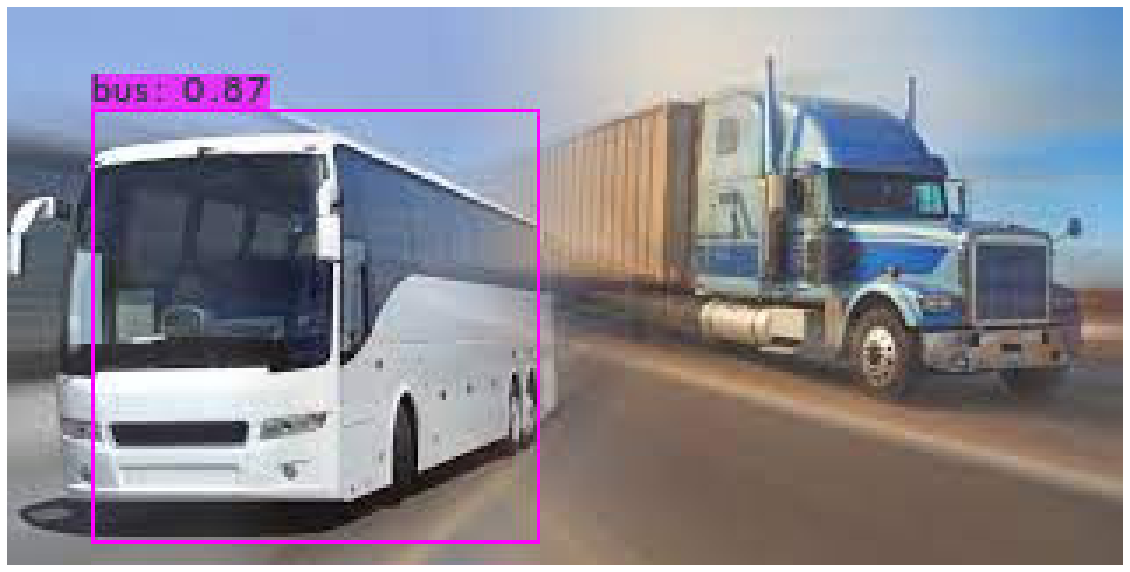

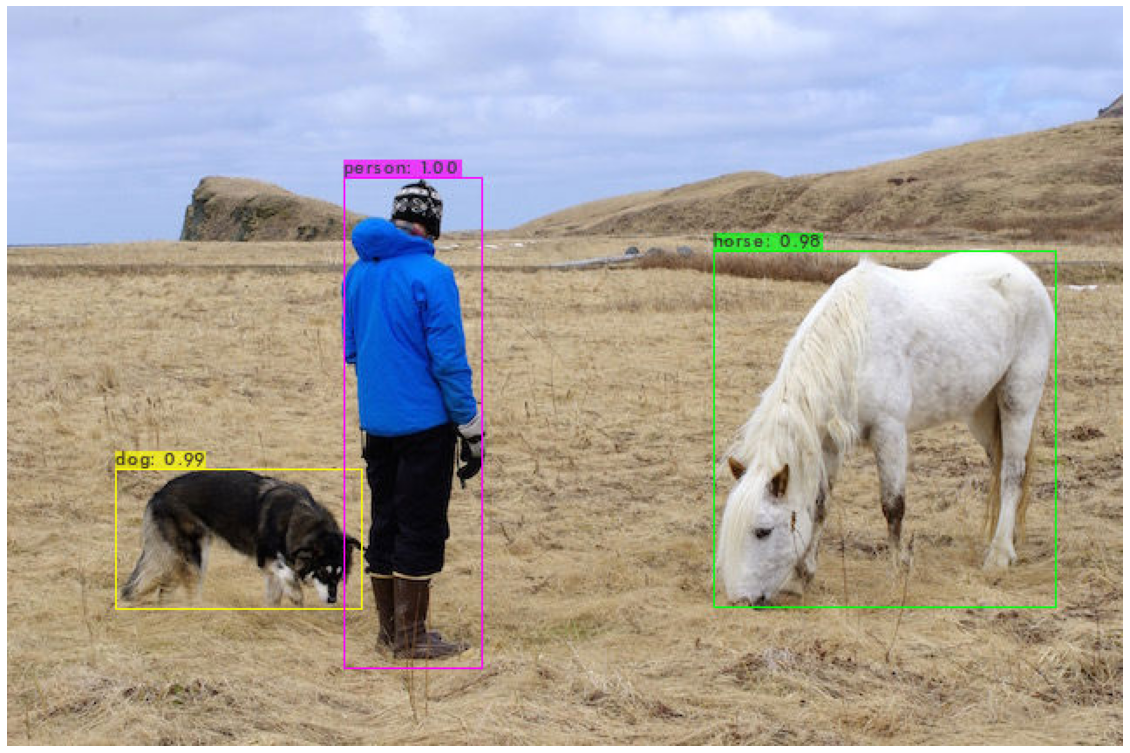

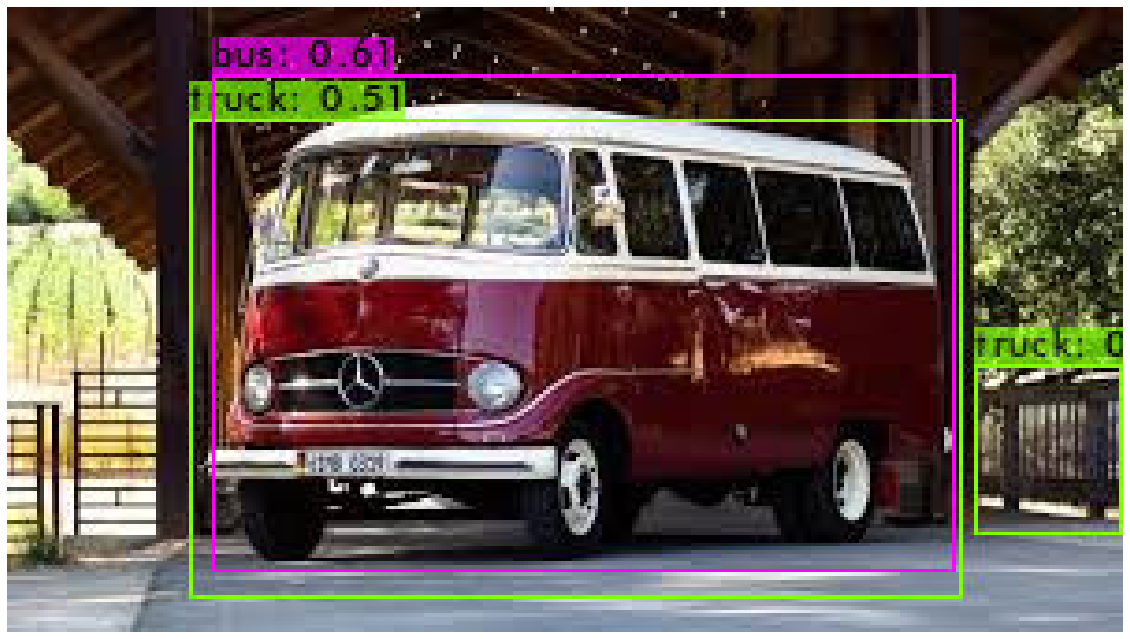

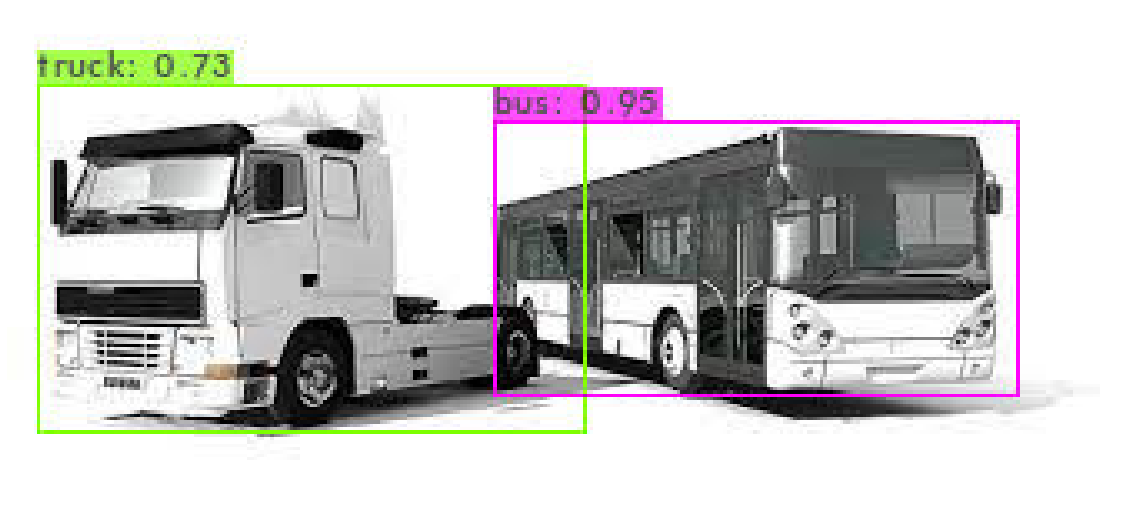

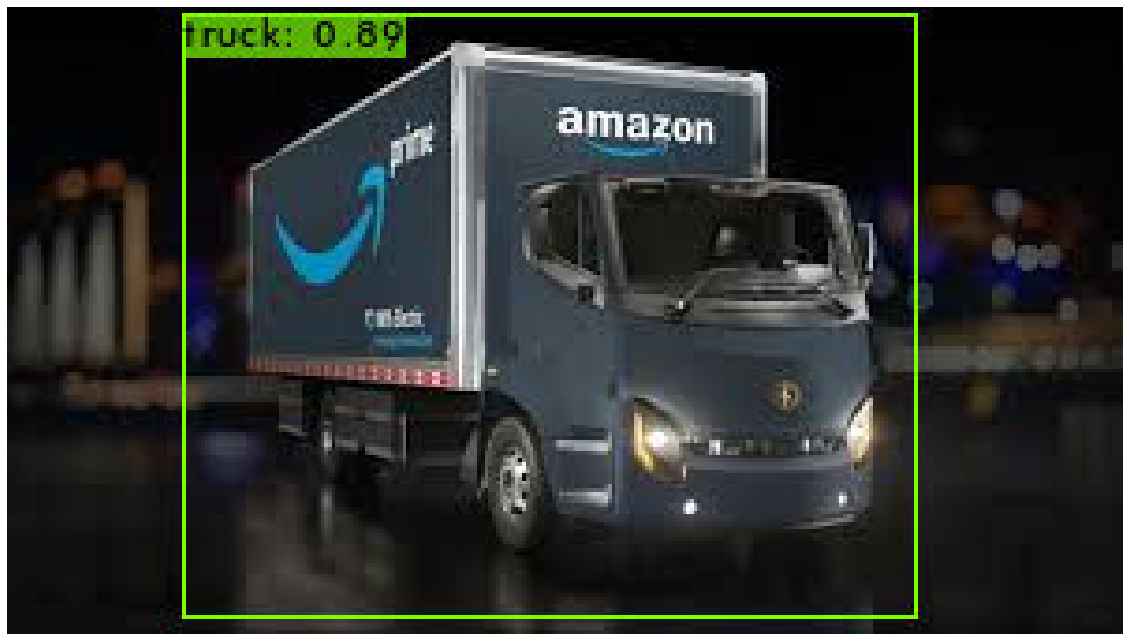

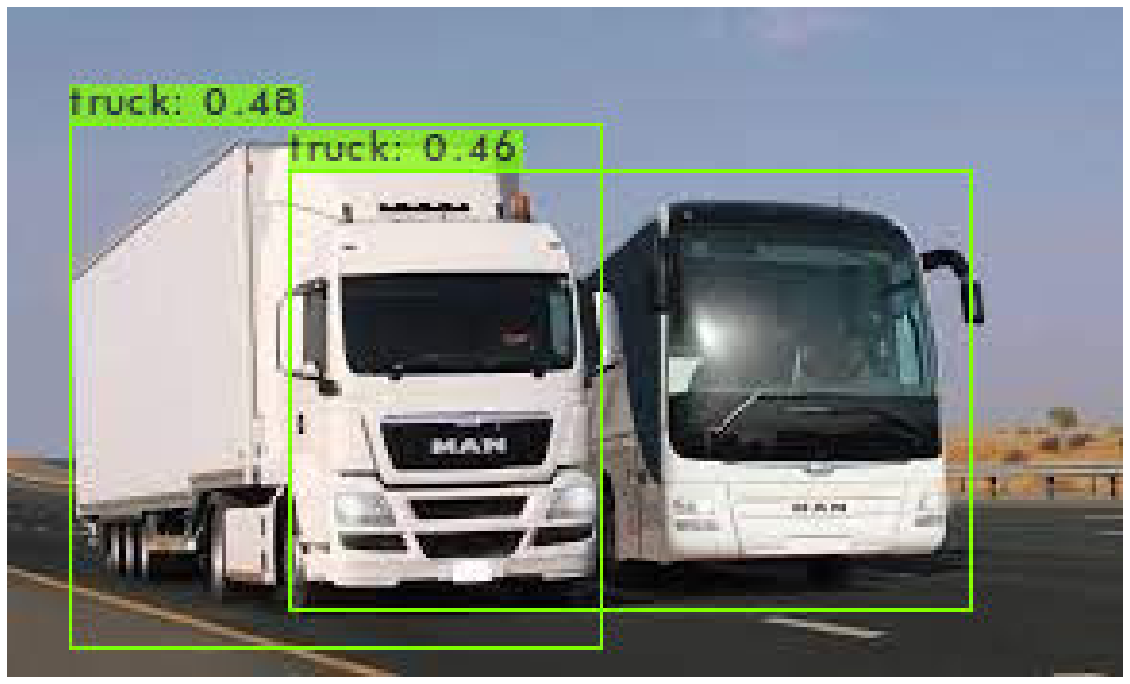

In [52]:
image_paths = Glob("images-of-trucks-and-busses")
for file in image_paths:
  !./darknet detector test data/obj.data cfg/yolov4-tiny-bus-trucks.cfg backup/yolov4-tiny-bus-trucks_4000.weights {file} 
  !mv predictions.jpg {stem(file)}_pred.jpg

for i in Glob("*_pred.jpg", silent=True):
  show(read(i, 1), sz=20)

Now that we have learned about leveraging YOLO to perform object detection on our custom dataset, in the next notebook, we will learn about leveraging SSD to perform object detection.